1. Original Soybean price from Brizal

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

In [2]:
def read_data(file_path):
    """Reads the CSV data file into a pandas DataFrame."""
    return pd.read_excel(file_path, parse_dates=['Date'], index_col='Date', header=3)

file_path = '../data/soybean.xls'
data = read_data(file_path)
data.head()

,Price
Date,
2006-03-13,12.96
2006-03-14,12.91
2006-03-15,13.00
2006-03-16,12.78
2006-03-17,12.68


2. Check for missing holiday and weekend data

In [3]:
# Check for missing holiday and weekend data
def check_missing_dates(data):
    """Checks for missing dates in the DataFrame index."""
    all_dates = pd.date_range(start=data.index.min(), end=data.index.max(), freq='D')
    missing_dates = all_dates.difference(data.index)
    return missing_dates
missing_dates = check_missing_dates(data)
print("Missing Dates:", missing_dates)

Missing Dates: DatetimeIndex(['2006-03-18', '2006-03-19', '2006-03-25', '2006-03-26',
               '2006-04-01', '2006-04-02', '2006-04-08', '2006-04-09',
               '2006-04-14', '2006-04-15',
               ...
               '2025-09-13', '2025-09-14', '2025-09-20', '2025-09-21',
               '2025-09-27', '2025-09-28', '2025-10-04', '2025-10-05',
               '2025-10-11', '2025-10-12'],
              dtype='datetime64[ns]', length=2270, freq=None)


In [4]:
# fill missing dates with NaN values
data_with_na = data.asfreq('D')
data_with_na.head(10)


,Price
Date,
2006-03-13,12.96
2006-03-14,12.91
2006-03-15,13.00
2006-03-16,12.78
2006-03-17,12.68
2006-03-18,NaN
2006-03-19,NaN
2006-03-20,12.73
2006-03-21,12.67


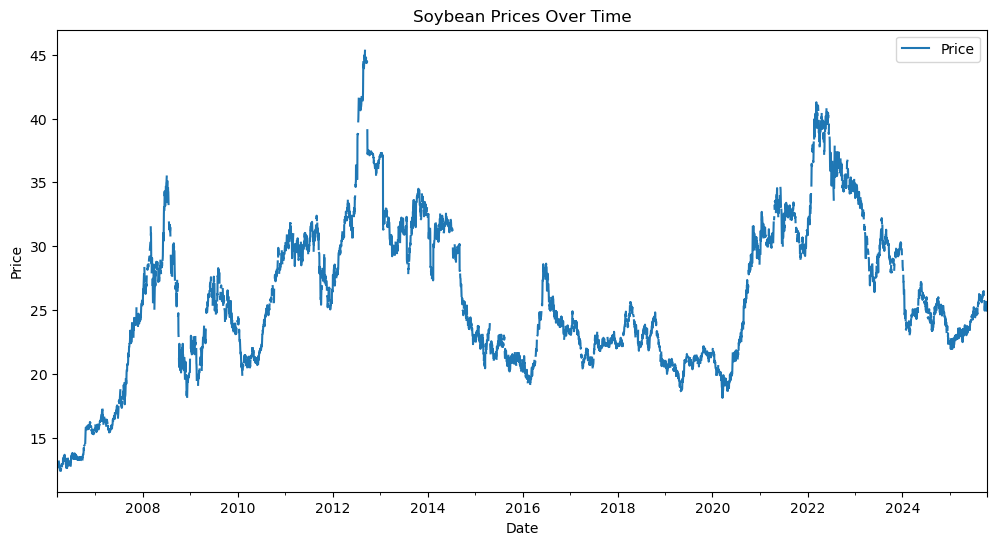

In [5]:
# visualize the data
import matplotlib.pyplot as plt
data_with_na.plot(figsize=(12, 6))
plt.title('Soybean Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [6]:
from pykalman import KalmanFilter

# kalman filtering for missing data imputation
def kalman_impute(data,column='Price'):
    """Imputes missing values in the DataFrame using Kalman filtering."""
    data_masked = np.ma.masked_invalid(data[column].values)
    kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)
    kf = kf.em(data_masked, n_iter=5)
    imputed_data, _ = kf.smooth(data_masked)
    data_imputed = data.copy()
    data_imputed[column] = imputed_data.round(2)
    return data_imputed

imputed_data = kalman_impute(data_with_na, column='Price')
imputed_data.head(10)

,Price
Date,
2006-03-13,12.66
2006-03-14,12.84
2006-03-15,12.91
2006-03-16,12.80
2006-03-17,12.72
2006-03-18,12.73
2006-03-19,12.73
2006-03-20,12.73
2006-03-21,12.74


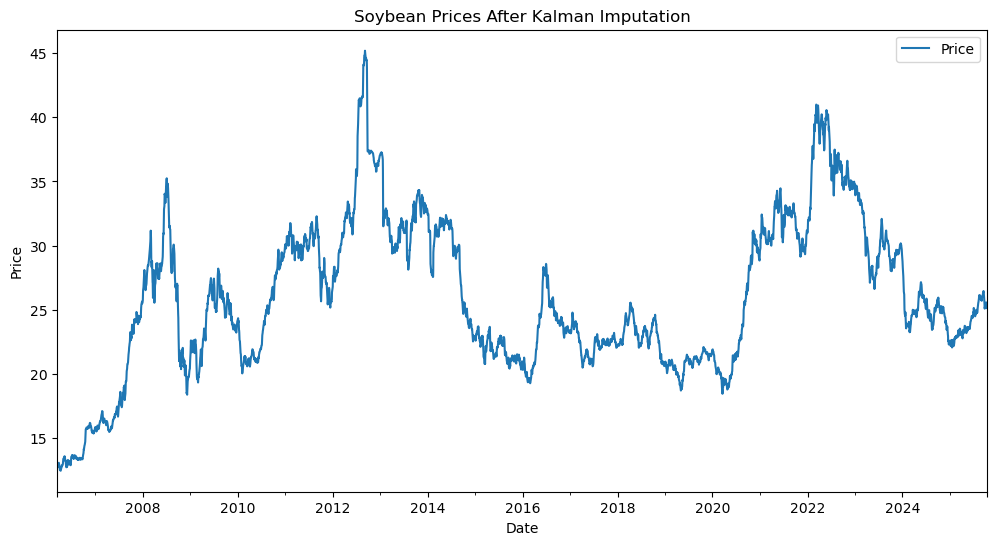

In [7]:
imputed_data.plot(figsize=(12, 6))
plt.title('Soybean Prices After Kalman Imputation')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [8]:
# Extract data from September 30, 2020, to September 30, 2025, for analysis.
analysis_data = imputed_data['2020-09-30':'2025-09-30']
analysis_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1827 entries, 2020-09-30 to 2025-09-30
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   1827 non-null   float64
dtypes: float64(1)
memory usage: 28.5 KB


In [32]:
# save the processed data
analysis_data.to_csv('../data/processed_soybean_price.csv')

In [14]:
merged_data = []

In [15]:
# read the exogenous variables
weather_data = pd.read_csv('../data/exogenous_data/brazil_soybean_weather_2015_2025.csv', parse_dates=['date'], index_col='date')
weather_data.head()
# extract relevant period
weather_data = weather_data['2020-09-30':'2025-09-30']
weather_data.tail()
# merge with soybean price data
merged_data = analysis_data.merge(weather_data, left_index=True, right_index=True)
merged_data.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1827 entries, 2020-09-30 to 2025-09-30
Freq: D
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Price                  1827 non-null   float64
 1   rain_Paranagua_PR      1827 non-null   float64
 2   temp_Paranagua_PR      1827 non-null   float64
 3   rain_MatoGrosso_MT     1827 non-null   float64
 4   temp_MatoGrosso_MT     1827 non-null   float64
 5   rain_Goias_GO          1827 non-null   float64
 6   temp_Goias_GO          1827 non-null   float64
 7   rain_MatoGrossoSul_MS  1827 non-null   float64
 8   temp_MatoGrossoSul_MS  1827 non-null   float64
 9   rain_RioGrandeSul_RS   1827 non-null   float64
 10  temp_RioGrandeSul_RS   1827 non-null   float64
dtypes: float64(11)
memory usage: 171.3 KB


In [16]:
brent_oil_data = pd.read_csv('../data/exogenous_data/brent_oil_futures.csv', parse_dates=['Date'], index_col='Date',header=0)
brent_oil_data.index = pd.to_datetime(brent_oil_data.index, utc=True).normalize().tz_localize(None)
brent_oil_data = brent_oil_data['2020-09-30':'2025-09-30']
brent_oil_data = brent_oil_data.asfreq('D')
# extract Date and Close columns and set Close to brent_oil column
brent_oil_data = brent_oil_data[['Close']]
# set column name to brent_oil
brent_oil_data.columns = ['brent_oil']
brent_oil_data_imputed = kalman_impute(brent_oil_data, column='brent_oil')
brent_oil_data_imputed.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1827 entries, 2020-09-30 to 2025-09-30
Freq: D
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   brent_oil  1827 non-null   float64
dtypes: float64(1)
memory usage: 28.5 KB


In [17]:
# merge with existing merged_data
merged_data = merged_data.merge(brent_oil_data_imputed, left_index=True, right_index=True)
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1827 entries, 2020-09-30 to 2025-09-30
Freq: D
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Price                  1827 non-null   float64
 1   rain_Paranagua_PR      1827 non-null   float64
 2   temp_Paranagua_PR      1827 non-null   float64
 3   rain_MatoGrosso_MT     1827 non-null   float64
 4   temp_MatoGrosso_MT     1827 non-null   float64
 5   rain_Goias_GO          1827 non-null   float64
 6   temp_Goias_GO          1827 non-null   float64
 7   rain_MatoGrossoSul_MS  1827 non-null   float64
 8   temp_MatoGrossoSul_MS  1827 non-null   float64
 9   rain_RioGrandeSul_RS   1827 non-null   float64
 10  temp_RioGrandeSul_RS   1827 non-null   float64
 11  brent_oil              1827 non-null   float64
dtypes: float64(12)
memory usage: 185.6 KB


In [18]:
# read cbot data
cbot_data = pd.read_csv('../data/exogenous_data/cbot_soybean_futures.csv', parse_dates=['Date'], index_col='Date', header=0)
cbot_data.index = pd.to_datetime(cbot_data.index, utc=True).normalize().tz_localize(None)
cbot_data = cbot_data['2020-09-30':'2025-09-30']
cbot_data = cbot_data.asfreq('D')
# extract Date and Close columns and set Close to cbot_soybean column
cbot_data = cbot_data[['Close']]
# set column name to cbot_soybean
cbot_data.columns = ['cbot']
cbot_data_imputed = kalman_impute(cbot_data, column='cbot')
cbot_data_imputed.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1827 entries, 2020-09-30 to 2025-09-30
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   cbot    1827 non-null   float64
dtypes: float64(1)
memory usage: 28.5 KB


In [19]:
# merge with existing merged_data
merged_data = merged_data.merge(cbot_data_imputed, left_index=True, right_index=True)
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1827 entries, 2020-09-30 to 2025-09-30
Freq: D
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Price                  1827 non-null   float64
 1   rain_Paranagua_PR      1827 non-null   float64
 2   temp_Paranagua_PR      1827 non-null   float64
 3   rain_MatoGrosso_MT     1827 non-null   float64
 4   temp_MatoGrosso_MT     1827 non-null   float64
 5   rain_Goias_GO          1827 non-null   float64
 6   temp_Goias_GO          1827 non-null   float64
 7   rain_MatoGrossoSul_MS  1827 non-null   float64
 8   temp_MatoGrossoSul_MS  1827 non-null   float64
 9   rain_RioGrandeSul_RS   1827 non-null   float64
 10  temp_RioGrandeSul_RS   1827 non-null   float64
 11  brent_oil              1827 non-null   float64
 12  cbot                   1827 non-null   float64
dtypes: float64(13)
memory usage: 199.8 KB


In [20]:
# read USD exchange rate data
usd_data = pd.read_csv('../data/exogenous_data/USD_BRL Historical Data.csv', parse_dates=['Date'], index_col='Date', header=0)
usd_data.index = pd.to_datetime(usd_data.index, utc=True).normalize().tz_localize(None)
usd_data.sort_index(inplace=True)
usd_data = usd_data['2020-09-30':'2025-09-30']
usd_data = usd_data.asfreq('D')
# extract Date and Close columns and set Close to usd_brl column
usd_data = usd_data[['Price']]
usd_data.columns = ['usd_brl']
# usd_data.info()
usd_data_imputed = kalman_impute(usd_data, column='usd_brl')
usd_data_imputed.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1827 entries, 2020-09-30 to 2025-09-30
Freq: D
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   usd_brl  1827 non-null   float64
dtypes: float64(1)
memory usage: 28.5 KB


In [21]:
# merge with existing merged_data
merged_data = merged_data.merge(usd_data_imputed, left_index=True, right_index=True)
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1827 entries, 2020-09-30 to 2025-09-30
Freq: D
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Price                  1827 non-null   float64
 1   rain_Paranagua_PR      1827 non-null   float64
 2   temp_Paranagua_PR      1827 non-null   float64
 3   rain_MatoGrosso_MT     1827 non-null   float64
 4   temp_MatoGrosso_MT     1827 non-null   float64
 5   rain_Goias_GO          1827 non-null   float64
 6   temp_Goias_GO          1827 non-null   float64
 7   rain_MatoGrossoSul_MS  1827 non-null   float64
 8   temp_MatoGrossoSul_MS  1827 non-null   float64
 9   rain_RioGrandeSul_RS   1827 non-null   float64
 10  temp_RioGrandeSul_RS   1827 non-null   float64
 11  brent_oil              1827 non-null   float64
 12  cbot                   1827 non-null   float64
 13  usd_brl                1827 non-null   float64
dtypes: float64(14)
memory usage: 2

In [22]:
# save the final merged data
merged_data.to_csv('../data/full_data.csv')

In [3]:
# read all data
full_data = pd.read_csv('../data/full_data.csv', parse_dates=['Date'], index_col='Date')
full_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1827 entries, 2020-09-30 to 2025-09-30
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Price                  1827 non-null   float64
 1   rain_Paranagua_PR      1827 non-null   float64
 2   temp_Paranagua_PR      1827 non-null   float64
 3   rain_MatoGrosso_MT     1827 non-null   float64
 4   temp_MatoGrosso_MT     1827 non-null   float64
 5   rain_Goias_GO          1827 non-null   float64
 6   temp_Goias_GO          1827 non-null   float64
 7   rain_MatoGrossoSul_MS  1827 non-null   float64
 8   temp_MatoGrossoSul_MS  1827 non-null   float64
 9   rain_RioGrandeSul_RS   1827 non-null   float64
 10  temp_RioGrandeSul_RS   1827 non-null   float64
 11  brent_oil              1827 non-null   float64
 12  cbot                   1827 non-null   float64
 13  usd_brl                1827 non-null   float64
dtypes: float64(14)
memory usage: 214.1 KB


In [4]:
full_data.columns

Index(['Price', 'rain_Paranagua_PR', 'temp_Paranagua_PR', 'rain_MatoGrosso_MT',
       'temp_MatoGrosso_MT', 'rain_Goias_GO', 'temp_Goias_GO',
       'rain_MatoGrossoSul_MS', 'temp_MatoGrossoSul_MS',
       'rain_RioGrandeSul_RS', 'temp_RioGrandeSul_RS', 'brent_oil', 'cbot',
       'usd_brl'],
      dtype='object')

In [5]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

def create_correlation_table(df, target_variable, exogenous_variables):
    """
    计算相关性，并根据您指定的 10%, 5%, 1% 显著性水平添加星号。
    """
    
    correlation_results = {}
    
    for var in exogenous_variables:
        # 准备数据：对齐目标变量和当前外生变量，并移除缺失值
        temp_df = df[[target_variable, var]].dropna()
        
        if len(temp_df) < 3:
            formatted_string = "N/A"
        else:
            # 计算皮尔逊相关系数 (r) 和 p-value
            corr, p_value = pearsonr(temp_df[target_variable], temp_df[var])
            
            # --- 按照您图中的注释规则添加星号 ---
            stars = ''
            if p_value < 0.01:
                stars = '***'
            elif p_value < 0.05:
                stars = '**'
            elif p_value < 0.10:
                stars = '*'
            # --------------------------------------
            
            # 格式化字符串，保留两位小数
            formatted_string = f"{corr:.2f}{stars}"
            
        correlation_results[var] = formatted_string
        
    # 将结果字典转换为 DataFrame
    final_table = pd.DataFrame.from_dict(
        correlation_results, 
        orient='index', 
        columns=[target_variable]
    )
    
    # 转置 (T) 表格，使格式与您的图片一致
    final_table = final_table.T
    final_table.index.name = 'Price series'
    
    return final_table

# --- 1. 定义您的变量 ---

# 这是您的因变量 (Y)
target_y = 'Price'

# 这是您提供的外生变量 (X) 列表
key_exog_vars = ['rain_Paranagua_PR', 'temp_Paranagua_PR','rain_MatoGrosso_MT',
'temp_MatoGrosso_MT', 'rain_Goias_GO', 'temp_Goias_GO',
'rain_MatoGrossoSul_MS', 'temp_MatoGrossoSul_MS',
'rain_RioGrandeSul_RS', 'temp_RioGrandeSul_RS', 'brent_oil', 'cbot',
'usd_brl']

# --- 2. 【请替换这里】加载您的数据 ---
# 
# (我在这里使用模拟数据，您必须用您自己的数据替换 'df_your_data')
#
# 示例：
df_your_data = full_data
# df_your_data = pd.read_excel("your_data.xlsx")
# print(df_your_data.head())


# --- 3. 运行分析并打印表格 ---

# 确保您的数据中包含 Y 和所有的 X 变量
all_required_columns = [target_y] + key_exog_vars
if not all(col in df_your_data.columns for col in all_required_columns):
    print("错误：您的 DataFrame 中缺少必要的列！")
else:
    # 运行函数
    correlation_table = create_correlation_table(df_your_data, target_y, key_exog_vars)
    
    # 打印格式化的 Markdown 表格
    print("--- 大豆价格相关性分析表 ---")
    print(correlation_table)

--- 大豆价格相关性分析表 ---
             rain_Paranagua_PR temp_Paranagua_PR rain_MatoGrosso_MT  \
Price series                                                          
Price                   0.05**          -0.11***               0.01   

             temp_MatoGrosso_MT rain_Goias_GO temp_Goias_GO  \
Price series                                                  
Price                  -0.15***          0.03      -0.18***   

             rain_MatoGrossoSul_MS temp_MatoGrossoSul_MS rain_RioGrandeSul_RS  \
Price series                                                                    
Price                       0.06**              -0.19***                -0.02   

             temp_RioGrandeSul_RS brent_oil     cbot   usd_brl  
Price series                                                    
Price                    -0.08***   0.53***  0.90***  -0.48***  


In [7]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

def create_detailed_selection_table(df, target_variable, exogenous_variables, significance_level=0.05):
    """
    计算每个变量的 R-squared 和 P-value，并标记是否显著。
    """
    results_list = []
    
    for var in exogenous_variables:
        # 1. 数据清洗
        temp_df = df[[target_variable, var]].dropna()
        
        if len(temp_df) < 3:
            continue # 数据不足跳过
            
        # 2. 计算统计量
        r, p_value = pearsonr(temp_df[target_variable], temp_df[var])
        
        # 3. 计算 R-squared (在单变量回归中，R^2 = r^2)
        r_squared = r ** 2
        
        # 4. 判断是否保留 (Selected)
        is_selected = p_value < significance_level
        
        # 5. 存入列表
        results_list.append({
            'Variable': var,
            'Pearson_r': r,       # 保留相关系数看方向 (+/-)
            'R_squared': r_squared,
            'P_value': p_value,
            'Selected': 'Yes' if is_selected else 'No'
        })
        
    # 转换为 DataFrame
    results_df = pd.DataFrame(results_list)
    
    # 按照 R_squared 降序排列 (解释力最强的在最上面)
    if not results_df.empty:
        results_df = results_df.sort_values(by='R_squared', ascending=False)
        results_df = results_df.set_index('Variable')

    print("selected variables based on p-value < {:.2f}: {}".format(significance_level,
          results_df[results_df['Selected'] == 'Yes'].index.tolist()))
    
    return results_df

def highlight_selected(row):
    """
    用于 Jupyter Notebook 的样式函数：如果 Selected 为 'Yes'，则整行标黄
    """
    color = 'background-color: #ffeb3b; color: black' if row['Selected'] == 'Yes' else ''
    return [color] * len(row)

# --- 1. 变量定义 ---
target_y = 'soybean_price'
key_exog_vars = [
    'usd_brl_rate', 'cbot_soybean_close', 'brent_oil_close', 'wti_oil_close',
    'rain_MatoGrosso_MT', 'temp_MatoGrosso_MT', 'rain_RioGrandeSul_RS',
    'temp_RioGrandeSul_RS', 'rain_Paranagua_PR', 'temp_Paranagua_PR',
    'rain_Goias_GO', 'temp_Goias_GO', 'rain_MatoGrossoSul_MS', 'temp_MatoGrossoSul_MS'
]

# --- 2. 加载数据 (请确保路径正确) ---
try:
    # 假设您的数据在这个路径
    raw_data = pd.read_csv('../data/soybean_integrated_data_complete.csv', parse_dates=['Date'], index_col='Date')
    
    # --- 3. 运行分析 ---
    # 检查列是否存在
    valid_vars = [col for col in key_exog_vars if col in raw_data.columns]
    
    if target_y not in raw_data.columns:
        print(f"错误: 目标变量 {target_y} 不在数据中。")
    else:
        # 生成表格
        selection_table = create_detailed_selection_table(raw_data, target_y, valid_vars)
        
        # print(f"--- 变量筛选分析表 (基于 P < 0.05) ---")
        
        # 格式化打印 (文本模式)
        pd.set_option('display.float_format', lambda x: '%.4f' % x)
        print(selection_table)
        
        # --- 4. 如果您在 Jupyter Notebook 中，可以使用下面的代码显示高亮表格 ---
        # (在普通 Python 脚本中这行不会显示颜色，但在 Notebook 中会)
        styled_table = selection_table.style.apply(highlight_selected, axis=1)\
            .format({'R_squared': '{:.4f}', 'P_value': '{:.4e}', 'Pearson_r': '{:.2f}'})
        
        # display(styled_table) # 如果在 Jupyter 中，取消这行的注释

except FileNotFoundError:
    print("找不到文件，请检查路径。")
except Exception as e:
    print(f"发生错误: {e}")

selected variables based on p-value < 0.05: ['cbot_soybean_close', 'brent_oil_close', 'wti_oil_close', 'usd_brl_rate', 'temp_MatoGrossoSul_MS', 'temp_Goias_GO', 'temp_MatoGrosso_MT', 'temp_Paranagua_PR', 'temp_RioGrandeSul_RS', 'rain_MatoGrossoSul_MS', 'rain_Paranagua_PR']
                       Pearson_r  R_squared  P_value Selected
Variable                                                     
cbot_soybean_close        0.8962     0.8032   0.0000      Yes
brent_oil_close           0.5222     0.2727   0.0000      Yes
wti_oil_close             0.5181     0.2684   0.0000      Yes
usd_brl_rate             -0.4859     0.2361   0.0000      Yes
temp_MatoGrossoSul_MS    -0.1931     0.0373   0.0000      Yes
temp_Goias_GO            -0.1816     0.0330   0.0000      Yes
temp_MatoGrosso_MT       -0.1525     0.0232   0.0000      Yes
temp_Paranagua_PR        -0.1109     0.0123   0.0000      Yes
temp_RioGrandeSul_RS     -0.0770     0.0059   0.0010      Yes
rain_MatoGrossoSul_MS     0.0574     0.0033 

In [27]:
import pywt  # 引入小波变换库

# 1. 定义小波去噪函数 (The "WT" part)
def wavelet_denoising(data, wavelet='db4', level=2):
    """
    修正版：增加长度检查，确保去噪后的数据长度与原始输入完全一致。
    """
    # 1. 记录原始长度
    original_len = len(data)
    
    # 2. 分解
    coeff = pywt.wavedec(data, wavelet, mode="per", level=level)
    
    # 3. 计算阈值 (通用阈值)
    sigma = (1/0.6745) * np.nanmedian(np.abs(coeff[-1] - np.nanmedian(coeff[-1])))
    uthesh = sigma * np.sqrt(2 * np.log(len(data)))
    
    # 4. 阈值处理 (Soft Thresholding)
    # 对所有细节系数(detail coefficients)进行去噪
    coeff[1:] = (pywt.threshold(i, value=uthesh, mode='soft') for i in coeff[1:])
    
    # 5. 重构
    recon_data = pywt.waverec(coeff, wavelet, mode='per')
    
    # --- 【关键修复】 长度对齐 ---
    if len(recon_data) > original_len:
        # 如果变长了，直接截断后面多余的部分
        recon_data = recon_data[:original_len]
    elif len(recon_data) < original_len:
        # 如果变短了（极少见），用最后一个值填充
        recon_data = np.pad(recon_data, (0, original_len - len(recon_data)), 'edge')
        
    recon_data = np.round(recon_data, 4)
    return recon_data

1825 1825


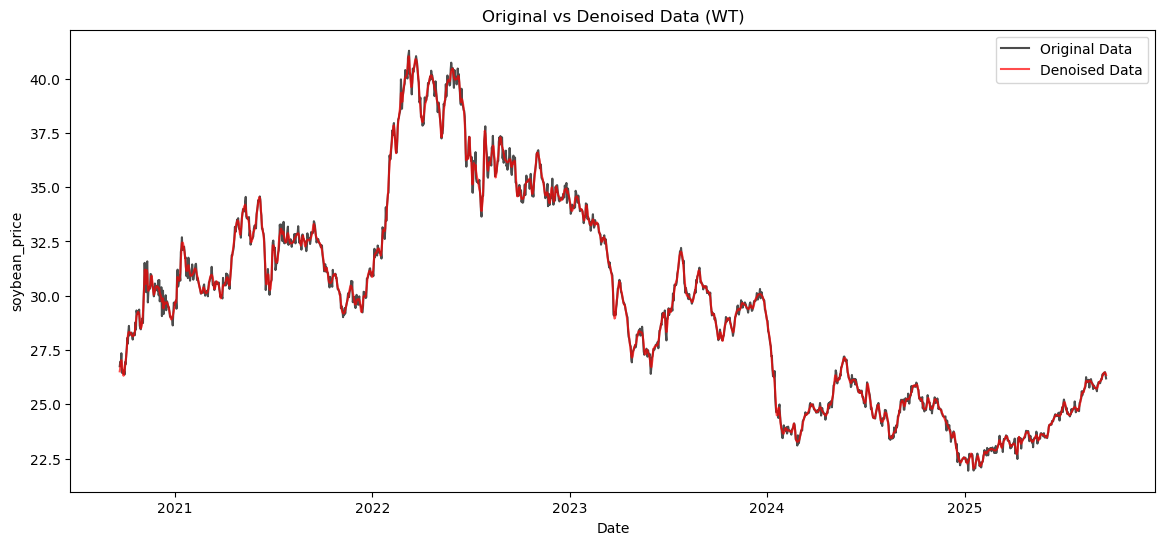

In [36]:
dn_data = wavelet_denoising(raw_data[target_y])  # 对原始数据进行去噪
print(len(dn_data), len(raw_data[target_y]))  # 检查长度是否一致
# 对比原始数据和去噪后的数据
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 6))
plt.plot(raw_data.index, raw_data[target_y], label='Original Data', alpha=0.7, color='black')
plt.plot(raw_data.index, dn_data, label='Denoised Data', alpha=0.7, color='red')
plt.title('Original vs Denoised Data (WT)')
plt.xlabel('Date')
plt.ylabel(target_y)
plt.legend()
plt.show()

In [33]:
from scipy.stats import pearsonr
# 引入 pykalman 库
from pykalman import KalmanFilter

# 1. 定义卡尔曼滤波去噪函数 (The "KF" part)
def kalman_denoising(data,n_iterations=5):
    """
    使用卡尔曼滤波对时间序列数据进行去噪。
    """
    """
    使用 pykalman 库进行自动参数估计和双向平滑。
    """
    # 1. 初始化 Kalman Filter
    # transition_matrices=[1]: 假设状态转移是 x(t) = 1 * x(t-1) + 噪声 (随机游走模型)
    # observation_matrices=[1]: 假设观测值 y(t) = 1 * x(t) + 噪声
    kf = KalmanFilter(transition_matrices=[1], observation_matrices=[1])

    # 2. 自动参数学习 (EM 算法)
    # 这步非常强大，它会自动寻找最佳的 transition_covariance (Q) 和 observation_covariance (R)
    kf = kf.em(data, n_iter=n_iterations)
    
    # 3. 平滑 (Smoothing)
    # smooth 方法会同时利用过去和未来的数据，比单纯的 filter 效果更好
    (smoothed_state_means, smoothed_state_covariances) = kf.smooth(data)
    
    # smoothed_state_means 是二维数组 (N, 1)，我们需要展平成一维
    return smoothed_state_means

1825 1825


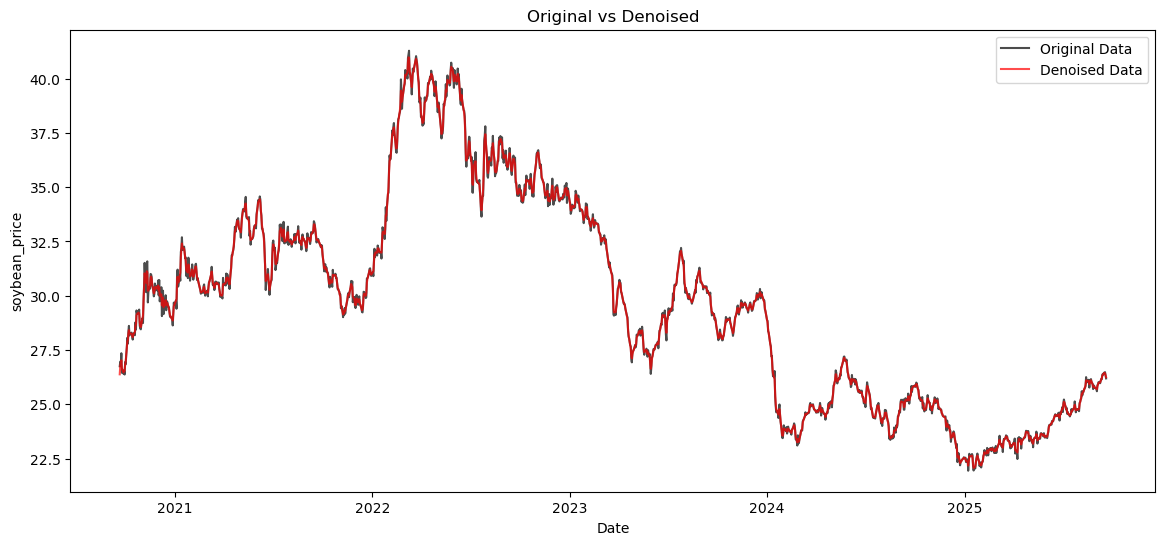

In [38]:
kl_dn = kalman_denoising(raw_data[target_y].values)  # 对原始数据进行卡尔曼滤波去噪
print(len(kl_dn), len(raw_data[target_y]))  # 检查长度是否
# 对比原始数据和去噪后的数据
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 6))
plt.plot(raw_data.index, raw_data[target_y], label='Original Data', alpha=0.7, color='black')
plt.plot(raw_data.index, kl_dn, label='Denoised Data', alpha=0.7, color='red')
plt.title('Original vs Denoised')
plt.xlabel('Date')
plt.ylabel(target_y)
plt.legend()
plt.show()